In [20]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('..')
sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import matthews_corrcoef

import category_encoders as ce

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder, CatBoostEncoder


import gc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
data_path = f'../../data/'
train_path = data_path + 'train.csv'
test_path = data_path + 'test.csv'
submission_path = data_path + 'sample_submission.csv'   

In [22]:
train = pd.read_csv(train_path)

In [23]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [25]:
# Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There 
# are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.

'''
The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom 
dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset 
as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.
'''

'\nThe dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom \ndataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset \nas part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.\n'

In [26]:
label = ['class']

In [27]:
test = pd.read_csv(test_path)
test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [28]:
submision_sample = pd.read_csv(submission_path)
submision_sample.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


# Train analysis


some common data analysis

In [29]:
len(train), train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

(3116945, None)

In [30]:
label_cols  = ['class']
object_cols = train.select_dtypes(include='object').columns.difference(label_cols)
int_cols    = train.select_dtypes(include='int64').columns #only the id
float_cols  = train.select_dtypes(include='float64').columns

In [31]:
train[object_cols]

,cap-color,cap-shape,cap-surface,does-bruise-or-bleed,gill-attachment,gill-color,gill-spacing,habitat,has-ring,ring-type,season,spore-print-color,stem-color,stem-root,stem-surface,veil-color,veil-type
0,u,f,s,f,a,w,c,d,f,f,a,NaN,w,NaN,NaN,NaN,NaN
1,o,x,h,f,a,n,c,d,t,z,w,NaN,o,NaN,y,NaN,NaN
2,b,f,s,f,x,w,c,l,f,f,w,NaN,n,NaN,s,NaN,NaN
3,g,f,y,f,s,g,NaN,d,f,f,u,NaN,w,NaN,NaN,NaN,NaN
4,w,x,l,f,d,w,NaN,g,f,f,a,NaN,w,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,n,f,NaN,t,NaN,w,NaN,d,t,g,u,NaN,w,b,NaN,w,u
3116941,w,s,NaN,t,d,p,c,d,f,f,u,NaN,w,NaN,NaN,NaN,NaN
3116942,e,x,e,f,a,w,NaN,d,t,z,a,NaN,y,NaN,NaN,w,NaN
3116943,n,p,i,t,e,p,NaN,d,t,p,u,NaN,w,NaN,y,NaN,NaN


In [32]:
train[float_cols]

,cap-diameter,stem-height,stem-width
0,8.80,4.51,15.39
1,4.51,4.79,6.48
2,6.94,6.85,9.93
3,3.88,4.16,6.53
4,5.85,3.37,8.36
...,...,...,...
3116940,9.29,12.14,18.81
3116941,10.88,6.65,26.97
3116942,7.82,9.51,11.06
3116943,9.45,9.13,17.77


# Part 2

In [33]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

secondary_mushroom = fetch_ucirepo(id=848)

X_original = secondary_mushroom.data.features
y_original = secondary_mushroom.data.targets

pd.concat((X_original, y_original)).to_csv('../../data/mushroom_original.csv', index=False)


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [34]:
# !pip install xgboost
# Standard
import warnings
import string

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef

from xgboost import XGBClassifier


warnings.filterwarnings('ignore')

In [35]:
# load data
df_train = pd.read_csv('../../data/train.csv').drop(['id'], axis=1)
train_original = pd.read_csv("../../data/mushroom_original.csv")
df_train = pd.concat([df_train, train_original], ignore_index=True)

df = df_train.drop_duplicates(subset=df_train.columns.to_list().remove('class'), keep='first')
test = pd.read_csv("../../data/test.csv")
sub = pd.read_csv("../../data/sample_submission.csv")

# quick view
print("Training data shape:", df.shape)

Training data shape: (3177870, 21)


In [36]:
print("Training data shape:", df.shape)
# explore dataset
print("\nDataset Info:")
print(df.info())
print("-----------------------------------------\nFirst few rows:")
df.head()

Training data shape: (3177870, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177870 entries, 0 to 3179073
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
m

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [37]:
def preprocess_categorical_data(df):
    """
    Preprocesses the DataFrame by replacing non-alphabetical characters in categorical columns 
    and imputing missing values in categorical columns using mode and in numeric columns using median.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    
    Returns:
    - pd.DataFrame: The processed DataFrame.
    """
    def replace_non_alphabetical(value):
        """Replaces non-alphabetical values with NaN if they are not a single character."""
        if isinstance(value, str) and (len(value) == 1 and value.isalpha()):
            return value
        return np.nan

    # Identify categorical and numeric columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Replace non-alphabetical values with NaN in categorical columns
    for col in categorical_columns:
        df[col] = df[col].apply(replace_non_alphabetical)
    
    # Impute missing values in categorical columns using mode
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'  # Safe mode handling
            df[col].fillna(mode_value, inplace=True)
    
    # Impute missing values in numeric columns using median
    for col in numeric_columns:
        if df[col].isnull().any():
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)

    return df
# Apply the functions to train and test data
print("Imputing noise with mode for categoricals and median for numericals...")
df = preprocess_categorical_data(df)
test = preprocess_categorical_data(test)



Imputing noise with mode for categoricals and median for numericals...


In [38]:
# Print summary of missing values after processing
print("\nMissing values in train_data after processing: ", df.isnull().sum().sum())
print("\nMissing values in test_data after processing: ", test.isnull().sum().sum())



Missing values in train_data after processing:  0

Missing values in test_data after processing:  0


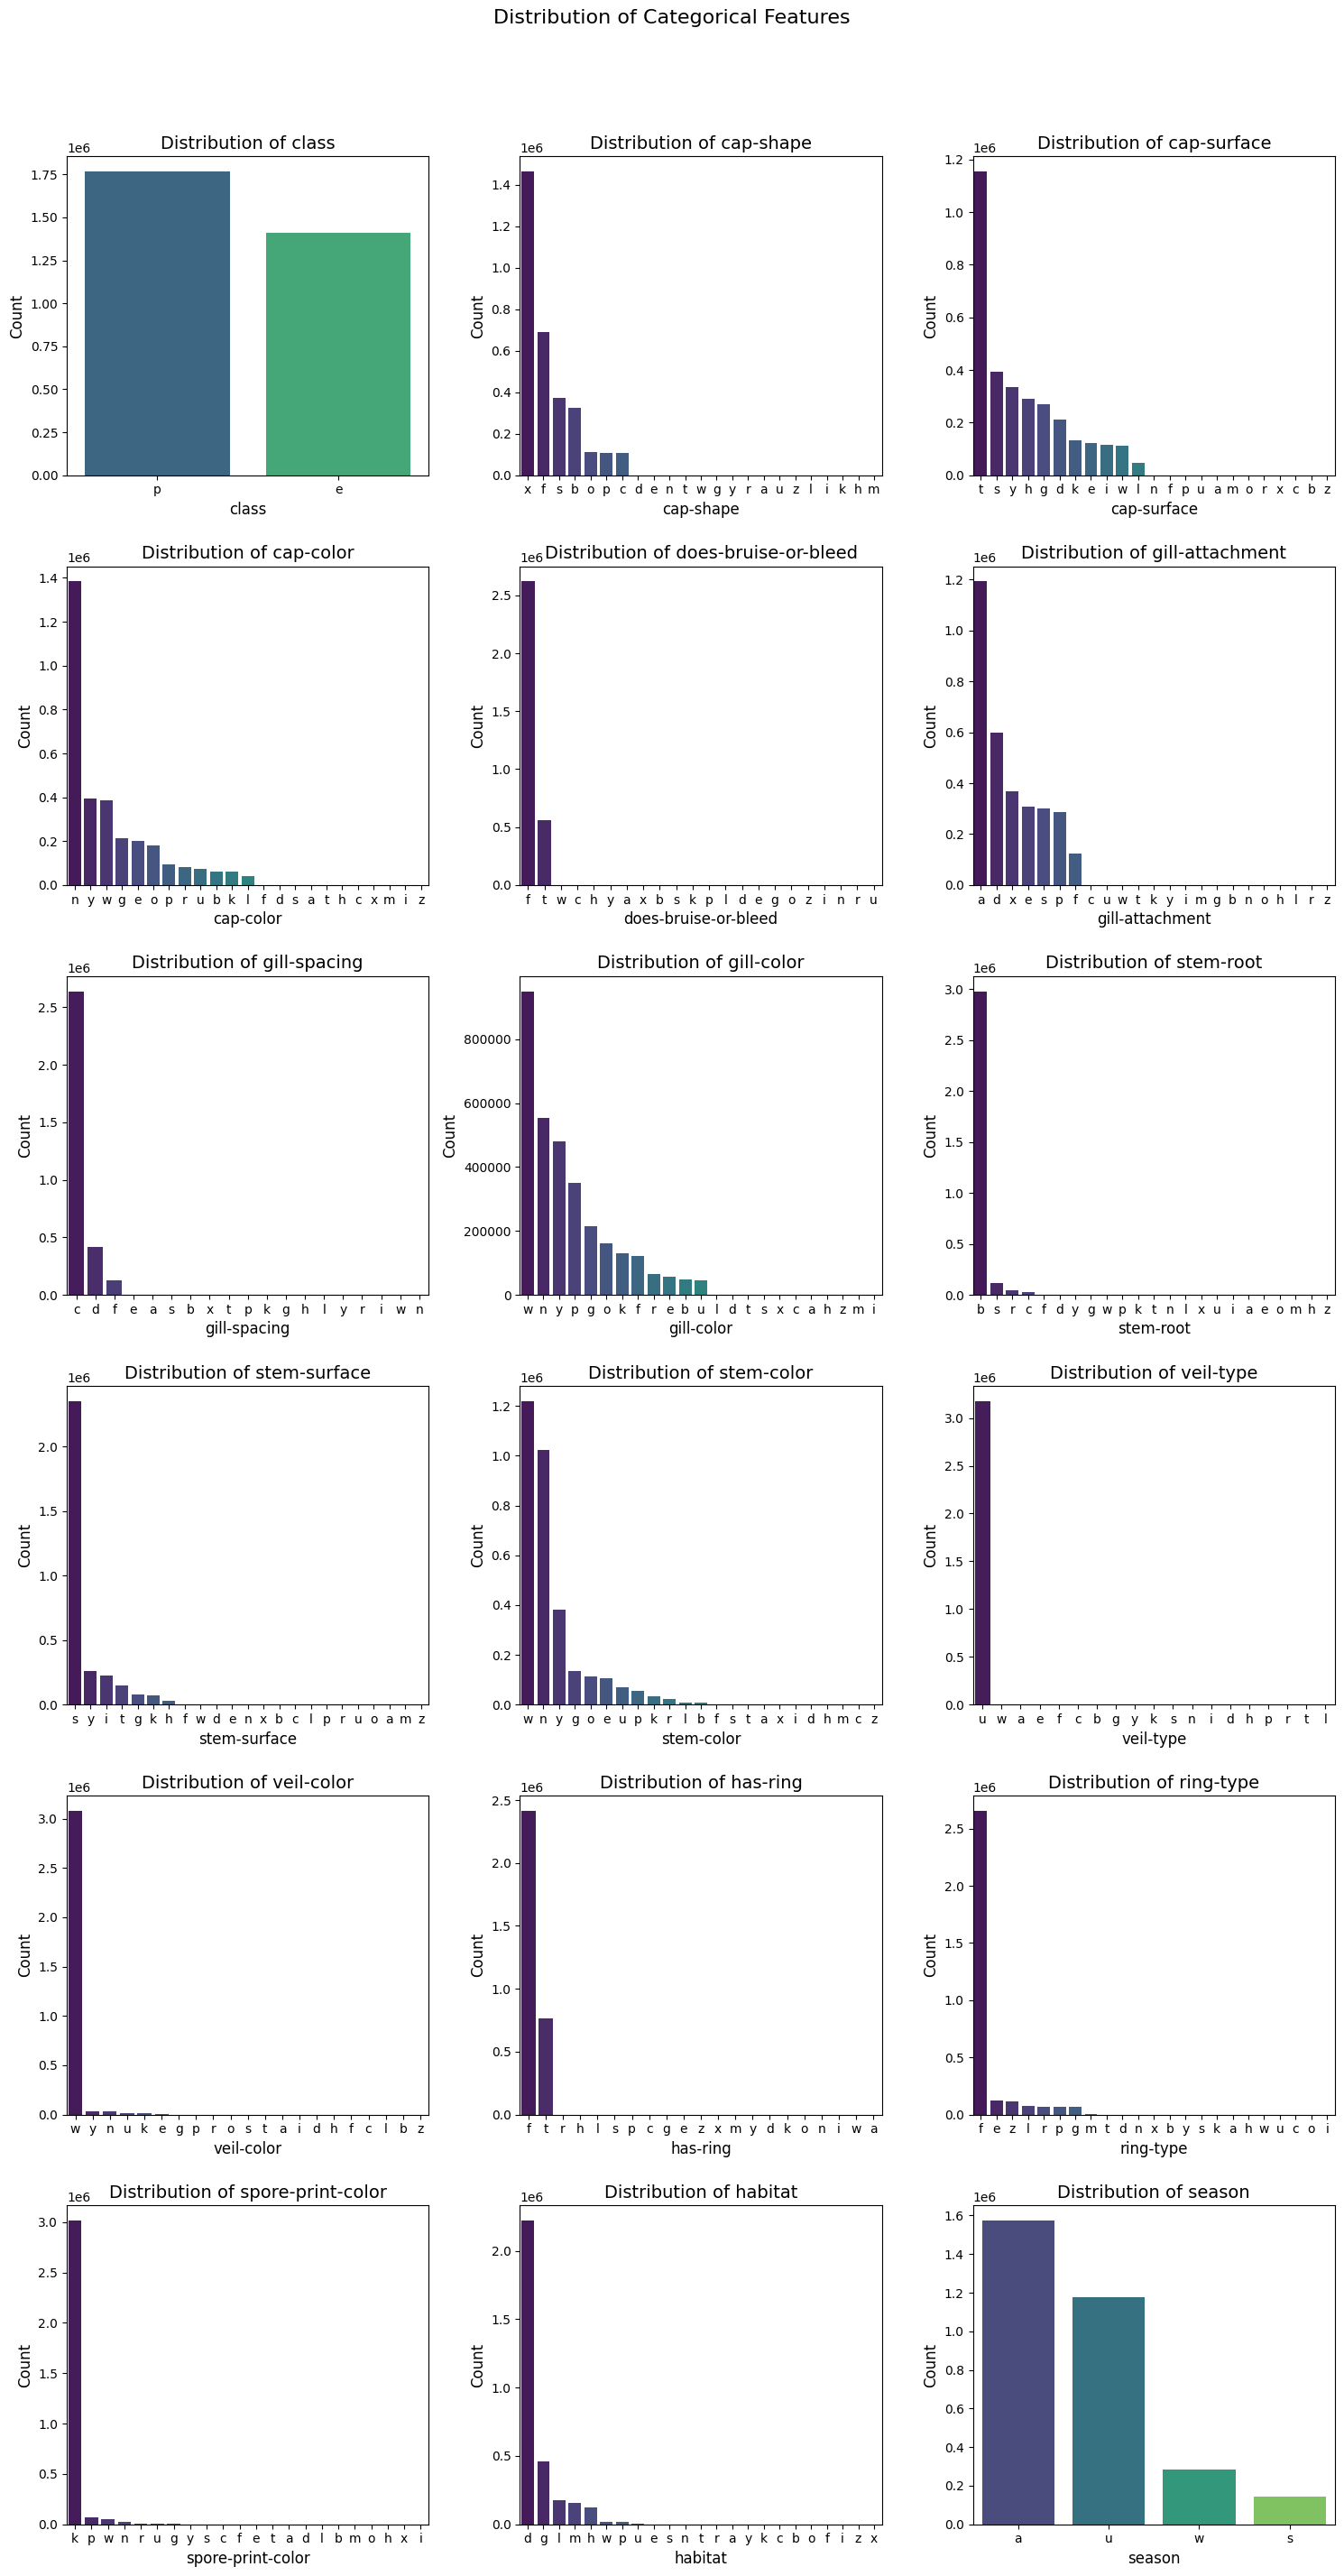

In [39]:
# Data Visualization and Analysis
def visualize_categorical_distributions(df):
    """
    Visualizes the distribution of categorical features in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the categorical features to visualize.
    
    Returns:
    - None: Displays the plots.
    """
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    fig.suptitle('Distribution of Categorical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each categorical column and create a bar plot
    for i, col in enumerate(categorical_columns):
        sns.barplot(
            x=df[col].value_counts().index, 
            y=df[col].value_counts().values, 
            ax=axes[i], 
            palette="viridis"
        )
        # Setting titles and labels
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].tick_params(axis='x')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

visualize_categorical_distributions(df)



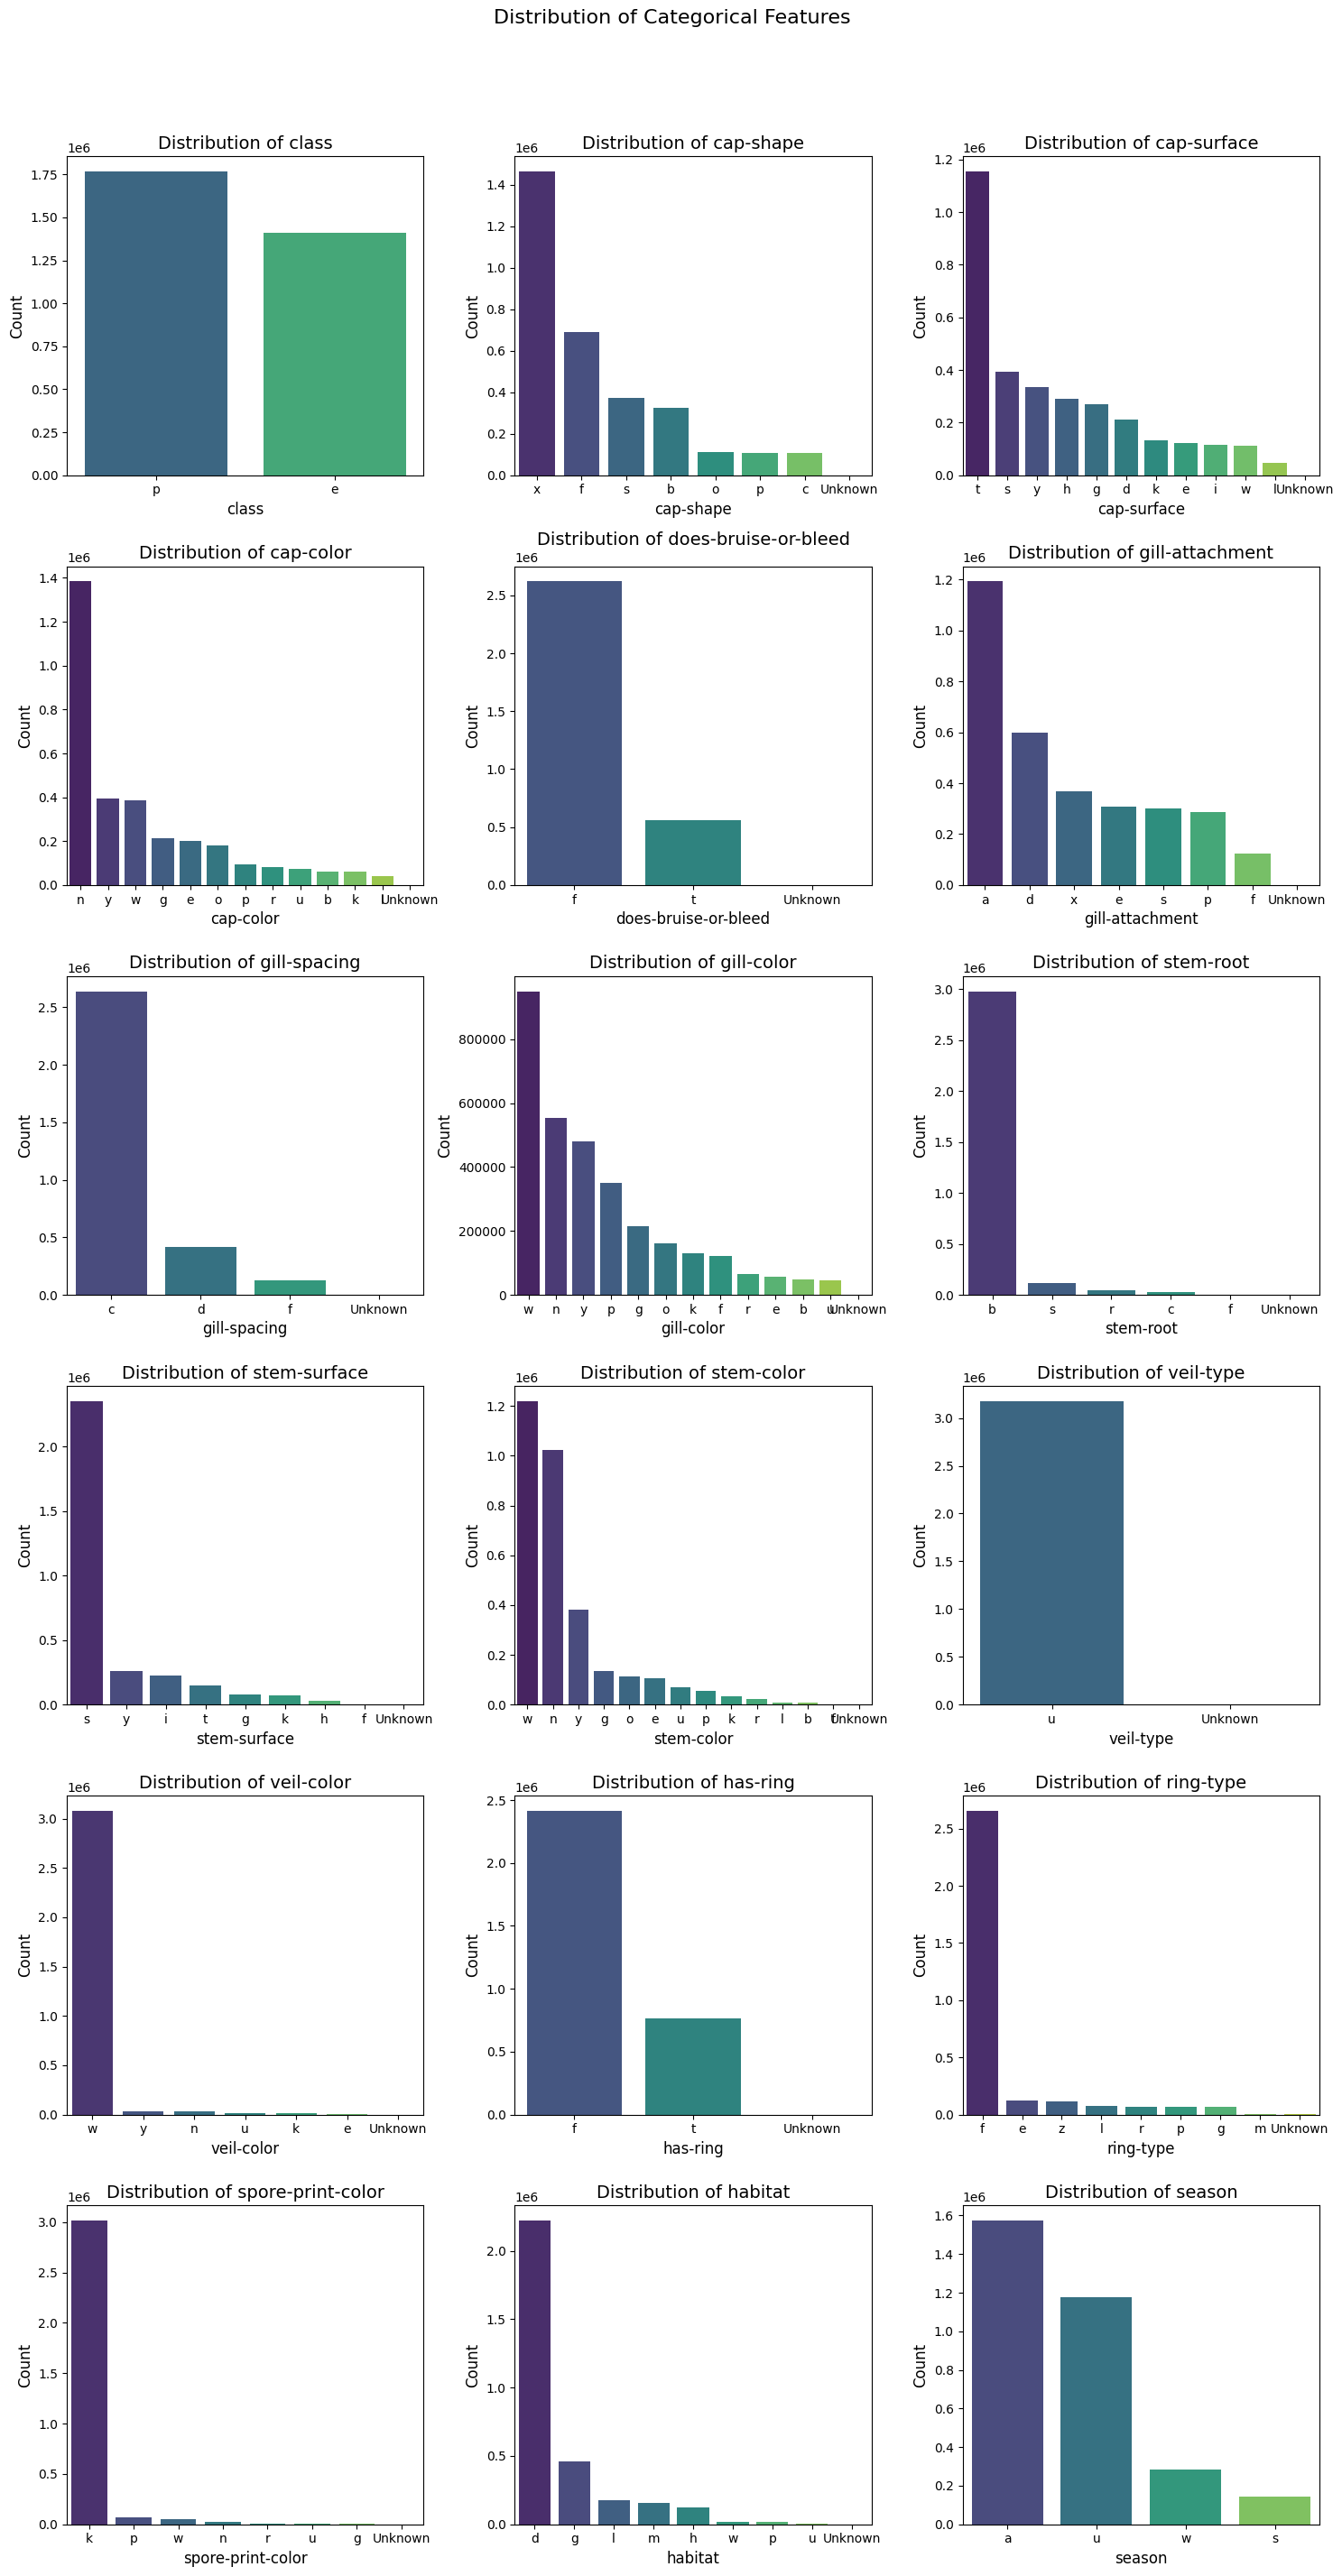

In [40]:
def categorize_low_frequency_values(df_train, df_test, threshold=100):
    """
    Replaces categories with less than a given threshold in all categorical columns 
    with the category 'Unknown', applying the same transformation to both training and test datasets.
    
    Parameters:
    - df_train (pd.DataFrame): The training DataFrame.
    - df_test (pd.DataFrame): The test DataFrame.
    - threshold (int): Frequency threshold below which categories are replaced with 'Unknown'.

    Returns:
    - df_train (pd.DataFrame): Modified training DataFrame.
    - df_test (pd.DataFrame): Modified test DataFrame.
    - mapping_dict (dict): Dictionary containing the mappings of replaced values for each column.
    """
    mapping_dict = {}
    
    # Identify categorical columns
    categorical_columns = df_test.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        # Find values to replace
        value_counts = df_train[col].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index
        
        # Update mapping dictionary with replacement to 'Unknown'
        mapping_dict[col] = {value: 'Unknown' for value in values_to_replace}
        
        # Replace in training and test data
        df_train[col] = df_train[col].replace(values_to_replace, 'Unknown')
        df_test[col] = df_test[col].replace(values_to_replace, 'Unknown')

    return df_train, df_test, mapping_dict

df, test, mappings = categorize_low_frequency_values(df, test)
visualize_categorical_distributions(df)

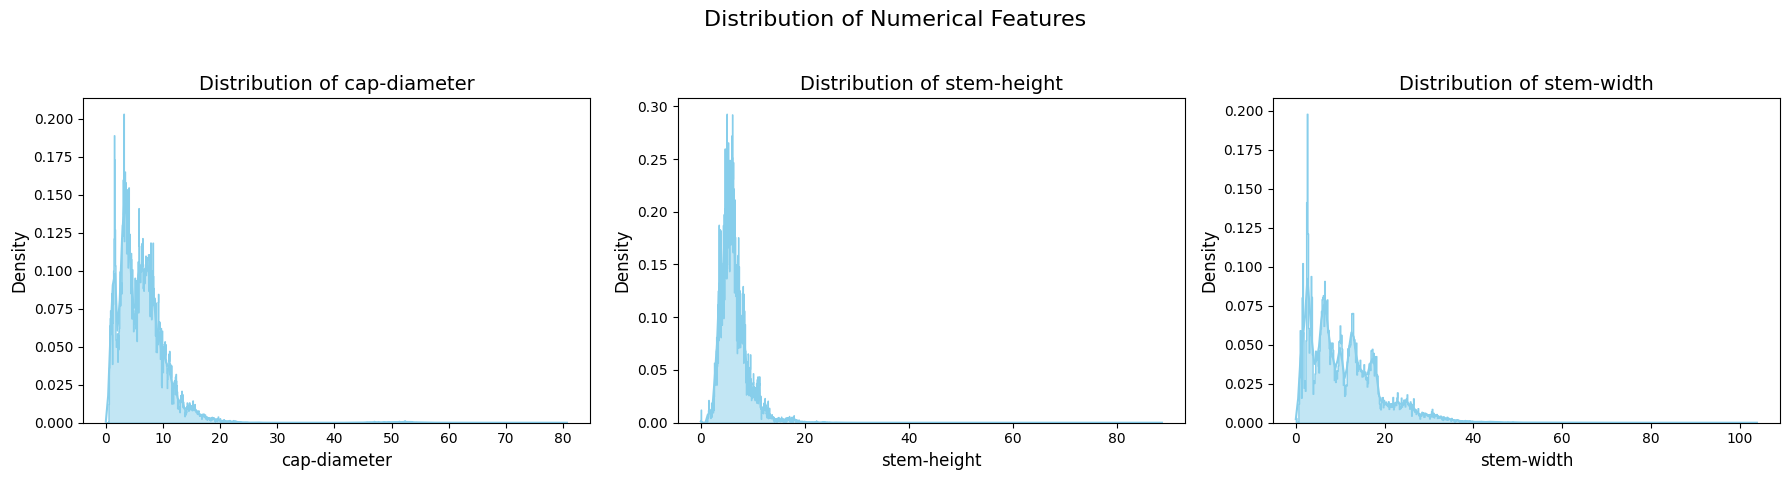

In [43]:
def visualize_numerical_distributions(df, exclude_columns='id'):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.
    
    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up the figure for multiple subplots num_cols = 3  # Number of columns for the subplot grid
    num_cols = 3
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

visualize_numerical_distributions(df)

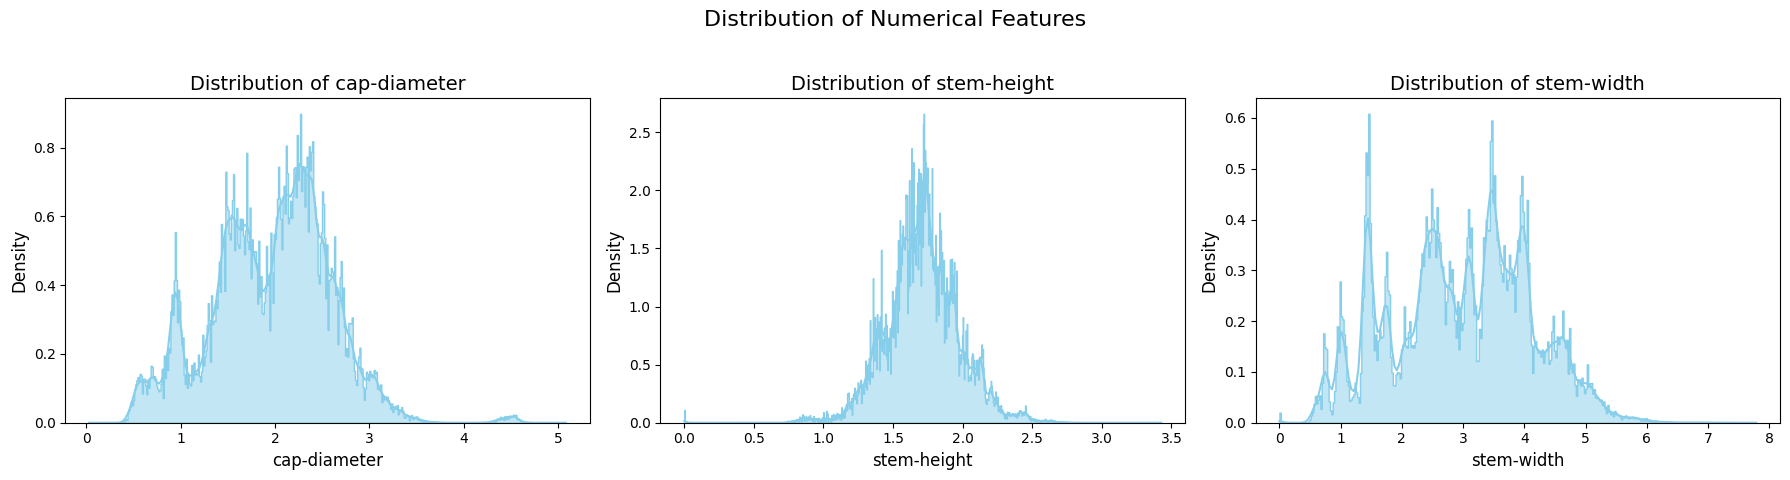

In [44]:
def handle_skewness(df, threshold=1.0):
    """
    Applies Box-Cox transformation to numerical columns in the DataFrame where skewness exceeds a threshold.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Skewness threshold to decide which columns to transform.
    
    Returns:
    - pd.DataFrame: DataFrame with transformed columns.
    - dict: Dictionary of lambda values used for Box-Cox transformation for each column.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    lambda_dict = {}
    
    for col in numeric_cols:
        skewness = df[col].skew()
        # Check the skewness and ensure positive values for Box-Cox
        if skewness > threshold:
            # Adding 1 to shift all data to positive if there are zero or negative values
            df[col] = df[col] + 1
            df[col], fitted_lambda = boxcox(df[col])
            lambda_dict[col] = fitted_lambda
    
    return df, lambda_dict

# Example usage:
# df is your DataFrame containing the numerical data
df, lambda_values = handle_skewness(df)
test, lambda_test = handle_skewness(test)

visualize_numerical_distributions(df, exclude_columns='id')


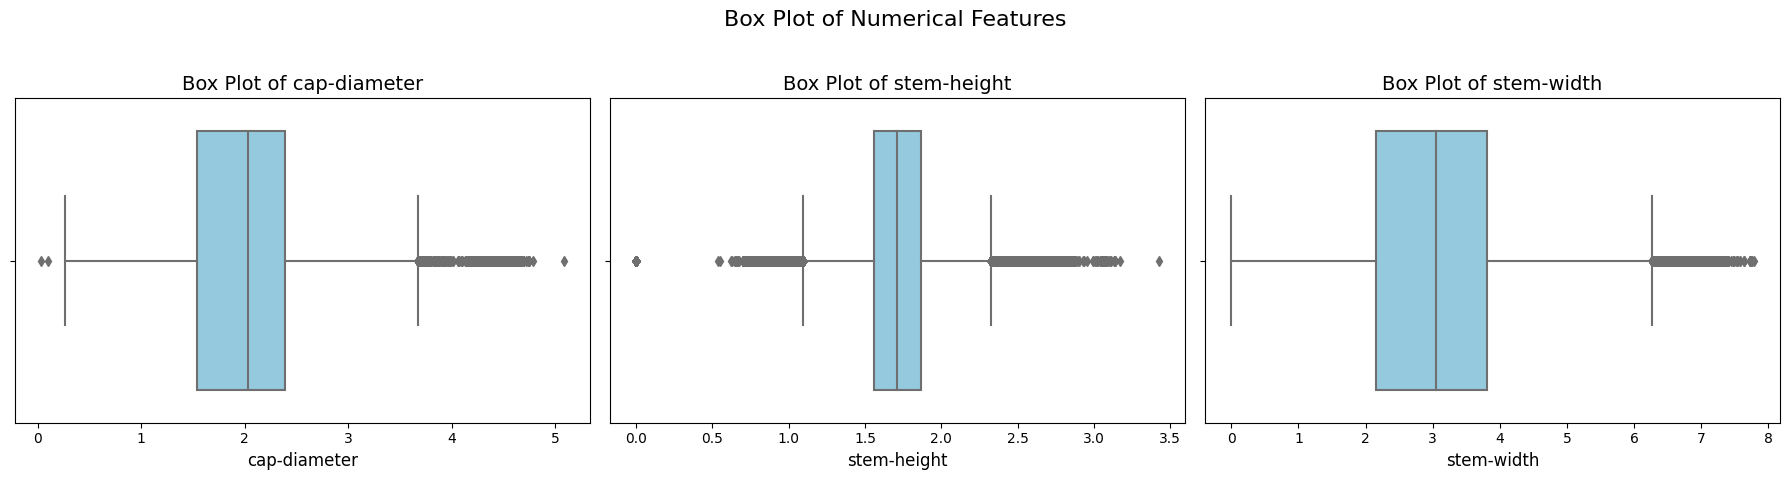

In [45]:
def visualize_box_plots(df):
    """
    Visualizes the distribution of numerical features in the DataFrame using box plots to identify outliers.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    
    Returns:
    - None: Displays the box plots.
    """
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Box Plot of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a box plot
    for i, col in enumerate(numerical_columns):
        sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f'Box Plot of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

visualize_box_plots(df)

In [46]:
def calculate_outliers_percentage(df):
    """
    Calculates the percentage of data considered outliers based on the IQR method for each numerical column.

    Parameters:
    - df (pd.DataFrame): DataFrame to analyze.

    Returns:
    - None: Prints the percentage of outliers for each numerical column.
    """
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")

# Example usage:
calculate_outliers_percentage(df)


Percentage of outliers in cap-diameter: 0.44%
Percentage of outliers in stem-height: 2.64%
Percentage of outliers in stem-width: 0.06%
